In [142]:
import numpy as np
from numpy import ndarray

from typing import Callable, Dict, Tuple, List

# В печати показывать только 4 цифры в числах с плавющей точкой
np.set_printoptions(precision=4)

Boston data

In [143]:
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score

In [144]:
boston = load_boston()

In [145]:
data = boston.data
target = boston.target
features = boston.feature_names

In [146]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [147]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target,
                                                    test_size=0.3,
                                                    random_state=80718)
# (354,) => (354, 1)
# или [36.2 15.  10.4] => [[36.2] [15.] [10.4]]
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

Линейная регрессия из библиотеки

In [148]:
from sklearn.linear_model import LinearRegression
# Данные необходимо централизовать fit_intercept=True
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

In [149]:
import matplotlib.pyplot as plt

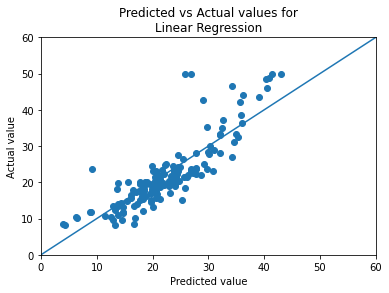

In [150]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs Actual values for\nLinear Regression")
rightup = 60
plt.xlim(([0, rightup]))
plt.ylim(([0, rightup]))
plt.scatter(preds, y_test)
plt.plot([0, rightup], [0, rightup])
# Пояснение: в идеале preds и y_test должны совпадать,
# То есть точки должны быть на прямой y=x

Ошибка модели

In [151]:
def mae(preds: ndarray, actuals: ndarray):
    """
    Средняя абсолютная ошибка
    """
    return np.mean(np.abs(preds - actuals))
def rmse(preds: ndarray, actuals:ndarray):
    '''
    Средняя квадратическкая ошибка
    :param preds:
    :param actuals:
    :return:
    '''
    return np.sqrt(np.mean(np.power(preds - actuals, 2)))

In [152]:
print("Mean absolute error: ", round(mae(preds, y_test), 4))
print("Root mean squared error:", round(rmse(preds, y_test), 4))

Mean absolute error:  3.5671
Root mean squared error: 5.0476


In [153]:
np.round(lr.coef_, 2)

array([[-1.01,  0.71,  0.28,  0.71, -2.21,  2.38,  0.71, -2.66,  2.63,
        -1.82, -2.33,  0.85, -4.19]])

Text(0.5, 1.0, 'Relationship between most\nimportant feature and target')

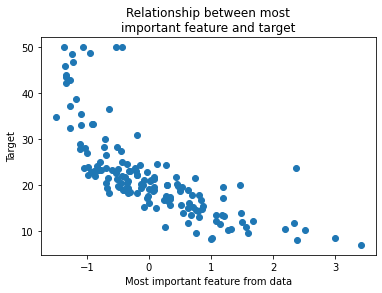

In [154]:
most_important = mi = np.argmax(np.abs(lr.coef_))
plt.scatter(X_test[:, mi], y_test)
plt.xlabel("Most important feature from data")
plt.ylabel("Target")
plt.title("Relationship between most\nimportant feature and target")

Своя линейная регрессия

In [155]:
def forward_loss(X_batch: ndarray,
                              y_batch: ndarray,
                              weights: Dict[str, ndarray]
                              ) -> Tuple[Dict[str, ndarray], float]:
    '''
    Прямой проход для линейной регрессии
    :param X_batch:
    :param y_batch:
    :param weights:
    :return: кортеж из ошибки и результатов прямого прохода
    '''
    # Проверяем совпадение размеров X и y
    assert X_batch.shape[0] == y_batch.shape[0]
    # Проверяем допустимость умножения матриц
    assert X_batch.shape[1] == weights['W'].shape[0]
    # Проверяем, что B - это объект ndarray размером 1х1
    assert weights['B'].shape[0] == weights['B'].shape[1] == 1

    N = np.dot(X_batch, weights['W'])

    P = N + weights['B']

    # loss = np.mean(np.power(y_batch - P, 2))
    loss = rmse(y_batch, P)

    # сохранение информации, полученной во время прямого прохода
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X_batch
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y_batch

    return forward_info, loss

In [156]:
# Производная именно для среднеквадратической ошибкой
# dLdP = -2 * (Y - P)
# dPdN = np.ones_like(N)
# dNdW = np.transpose(X, (1,0))
# dPdB = np.ones_like(weight['B'])
def loss_gradients(forward_info: Dict[str, ndarray],
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    '''
    Вычисление dLdW и dLdB для модели линейной регрессии
    :param forward_info:
    :param weights:
    :return:
    '''
    batch_size = forward_info['X'].shape[0]

    dLdP = -2 * (forward_info['y'] - forward_info['P'])
    dPdN = np.ones_like(forward_info['N'])

    dLdN = dLdP * dPdN
    dNdW = np.transpose(forward_info['X'], (1, 0))

    # умножение матриц, в котором первым идет компонент dNdW
    dLdW = np.dot(dNdW, dLdN)

    # суммирование по измерению, представляющему размер набора
    dPdB = np.ones_like(weights['B'])
    dLdB = (dLdP * dPdB)
    dLdB = dLdB.sum(axis=0) # Автор позже объяснит, зачем это

    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = dLdB

    return loss_gradients

In [157]:
def to_2d_np(a: ndarray,
             type: str = 'col') -> ndarray:
    '''
    Turns a 1D Tensor into 2D
    :param a:
    :param type:
    :return:
    '''
    assert a.ndim == 1, \
    "Input tensor must be 1 dimensional"

    if type == 'col':
        return a.reshape(-1, 1)
    elif type == 'row':
        return a.reshape(1, -1)

In [158]:
def permute_data(X: ndarray,
                 y: ndarray):
    """Рандомная перестановка объектов"""
    assert X.shape[0] == y.shape[0]
    perm_ind = np.random.permutation(X.shape[0])
    return X[perm_ind], y[perm_ind]

In [159]:
Batch = Tuple[ndarray, ndarray]

def generate_batch(X: ndarray,
                   y: ndarray,
                   start: int = 0,
                   batch_size: int = 10
                   ) -> Batch:
    '''
    Generate batch from X and y, given a start position
    :param X:
    :param y:
    :param start:
    :param batch_size:
    :return:
    '''
    assert X.ndim == y.ndim == 2

    if start+batch_size > X.shape[0]:
        bach_size = X.shape[0] - start
    X_batch, y_batch = X[start:start+batch_size], y[start:start + batch_size]

    return X_batch, y_batch

In [160]:
def init_weights(n_in: int) -> Dict[str, ndarray]:
    """Веса для первого прохода модели"""
    weights: Dict[str, ndarray] = {}
    W = np.random.rand(n_in, 1)
    B = np.random.rand(1, 1)
    weights['W'] = W
    weights['B'] = B
    return weights

In [161]:
def train(X: ndarray,
          y: ndarray,
          n_iter: int = 100,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          seed: int = 1) -> Tuple[List, Dict[str, ndarray]]:
    """
    Тренировка модели определенное количество раз
    :param X:
    :param y:
    :param n_iter:
    :param learning_rate:
    :param batch_size:
    :param seed:
    :return:
    """
    if seed:
        np.random.seed(seed)
    start = 0

    weights = init_weights(X.shape[1])

    X, y = permute_data(X, y)

    losses = []

    for i in range(n_iter):
        # Generate batch
        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0

        X_batch, y_batch = generate_batch(X, y, start, batch_size)

        start += batch_size

        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]

    return losses, weights

In [162]:
n_iter = 1000
train_info = train(X_train, y_train,
                   n_iter=n_iter,
                   learning_rate=0.001,
                   batch_size=23,
                   seed=180708)
losses = train_info[0]
weights = train_info[1]

{'W': array([[-1.097 ],
       [ 0.7415],
       [ 0.2104],
       [ 0.7458],
       [-2.2873],
       [ 2.1985],
       [ 0.7221],
       [-2.6368],
       [ 2.5713],
       [-1.7278],
       [-2.3174],
       [ 0.8444],
       [-4.2567]]), 'B': array([[22.6313]])}
3.531402385615203


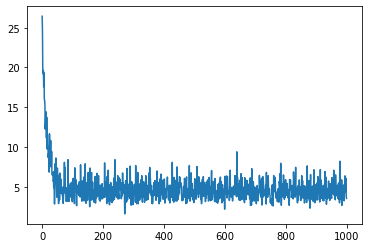

In [163]:
plt.plot(list(range(n_iter)), losses)

print(weights)
print(losses[-1])

In [164]:
def predict(X: ndarray,
            weights: Dict[str, ndarray]):
    """
    Генерация предсказаний для модели линейной регрессии
    :param X:
    :param weights:
    :return:
    """
    N = np.dot(X, weights['W'])
    return N + weights['B']

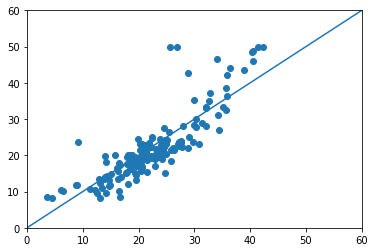

In [165]:
preds = predict(X_test, weights)

rightup = 60
plt.xlim(([0, rightup]))
plt.ylim(([0, rightup]))
plt.scatter(preds, y_test)
plt.plot([0, rightup], [0, rightup])

In [166]:
print("Mean absolute error: ", round(mae(preds, y_test), 4))
print("Root mean squared error:", round(rmse(preds, y_test), 4))

Mean absolute error:  3.5645
Root mean squared error: 5.0489


In [167]:
np.round(y_test.mean(), 4)

22.0776

In [168]:
np.round(rmse(preds, y_test)/y_test.mean(), 4)

0.2287

In [169]:
NUM = 40

# arr.sum(keepdims=True)) -> [15]
# arr.sum(keepdims=False)) -> 15

a = np.repeat(X_test[:, : -1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)
print("X_test", X_test)
print("X_test[:, : -1]", X_test[:, : -1])
print("X_test[:, : -1].mean(axis=0, keepdims=True)" , X_test[:, : -1].mean(axis=0, keepdims=True))
print("a", a[:3])


test_feature = np.concatenate([a, b], axis=1)

test_preds = predict(test_feature, weights)
print(test_preds.shape)
test_preds = test_preds[:, 0]
print(test_preds.shape)

X_test [[-0.4164  3.5896 -1.2339 ... -1.7364  0.3959 -1.2396]
 [ 1.6587 -0.4877  1.016  ...  0.8066  0.4064  1.2794]
 [ 0.2127 -0.4877  1.016  ...  0.8066 -0.0152  0.7117]
 ...
 [-0.3901 -0.4877 -0.1805 ... -0.0257  0.4345 -0.1308]
 [-0.416   1.7656 -0.8487 ... -0.8579  0.4411 -0.7728]
 [-0.4182  3.5896 -1.2339 ... -1.7364  0.3714 -1.3699]]
X_test[:, : -1] [[-0.4164  3.5896 -1.2339 ... -1.0942 -1.7364  0.3959]
 [ 1.6587 -0.4877  1.016  ...  1.5309  0.8066  0.4064]
 [ 0.2127 -0.4877  1.016  ...  1.5309  0.8066 -0.0152]
 ...
 [-0.3901 -0.4877 -0.1805 ... -0.6191 -0.0257  0.4345]
 [-0.416   1.7656 -0.8487 ... -0.6844 -0.8579  0.4411]
 [-0.4182  3.5896 -1.2339 ... -1.0942 -1.7364  0.3714]]
X_test[:, : -1].mean(axis=0, keepdims=True) [[-0.0094  0.0098 -0.0082  0.0904  0.0454 -0.0305  0.0165 -0.0188  0.011
   0.0074  0.0507  0.0345]]
a [[-0.0094  0.0098 -0.0082  0.0904  0.0454 -0.0305  0.0165 -0.0188  0.011
   0.0074  0.0507  0.0345]
 [-0.0094  0.0098 -0.0082  0.0904  0.0454 -0.0305  0.0165 

Text(0, 0.5, 'Target/Predictions')

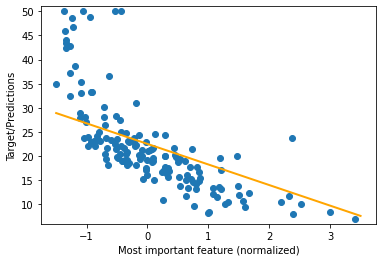

In [170]:
plt.scatter(X_test[:, mi], y_test)
# plt.plot(np.array(b), test_preds, linewidth=2, c='orange')
plt.plot(np.array(test_feature[:, -1]), test_preds, linewidth=2, c='orange')
plt.ylim([6, 51])
plt.xlabel("Most important feature (normalized)")
plt.ylabel("Target/Predictions")


Coefficients

In [171]:
# Перевод в одномерный массив (коэф своей линейной регрессии)
np.round(weights['W'].reshape(-1), 4)

array([-1.097 ,  0.7415,  0.2104,  0.7458, -2.2873,  2.1985,  0.7221,
       -2.6368,  2.5713, -1.7278, -2.3174,  0.8444, -4.2567])

In [172]:
# (коэф лин регрессии из scikit)
np.round(lr.coef_, 4)

array([[-1.0148,  0.7065,  0.276 ,  0.7092, -2.206 ,  2.3793,  0.7133,
        -2.6625,  2.6325, -1.8172, -2.3266,  0.8465, -4.1889]])

In [173]:
np.round(weights['B'], 4)

array([[22.6313]])

In [174]:
np.round(lr.intercept_, 4)

array([22.6195])

(6.0, 51.0)

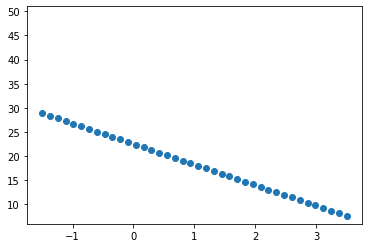

In [175]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)
test_feature = np.concatenate([a, b], axis=1)
preds = predict(test_feature, weights).reshape(-1)
plt.scatter(np.array(test_feature[:, -1]), np.array(preds))
plt.ylim([6, 51])

Neural network regression

In [176]:
def sigmoid(x: ndarray) -> ndarray:
    return 1 / (1 + np.exp(-1.0 * x))

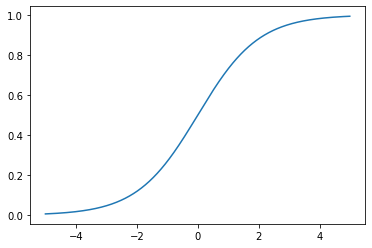

In [177]:
plt.plot(np.arange(-5, 5, 0.01),
         sigmoid(np.arange(-5, 5, 0.01)))

In [178]:
def init_weights(input_size: int,
                 hidden_size: int) -> Dict[str, ndarray]:
    """
    Инициализация весов для прямого прохождения шаг за шагов НС
    :param input_size:
    :param hidden_size:
    :return:
    """
    weights: Dict[str, ndarray] = {}
    # input_size x hidden_size
    weights['W1'] = np.random.randn(input_size, hidden_size)
    weights['B1'] = np.random.randn(1, hidden_size)
    # Скрытый слой (2 слой) состоит из hidden_size нейронов
    weights['W2'] = np.random.randn(hidden_size, 1)
    weights['B2'] = np.random.randn(1, 1)
    return weights

In [179]:
def forward_loss(X: ndarray,
                 y: ndarray,
                 weights: Dict[str, ndarray]
                 ) -> Tuple[Dict[str, ndarray], float]:
    """
    Прямой проход через модель нейронной сети и определение величины потерь
    :param X:
    :param y:
    :param weights:
    :return:
    """
    M1 = np.dot(X, weights['W1'])
    N1 = M1 + weights['B1']
    O1 = sigmoid(N1)

    M2 = np.dot(O1, weights['W2'])

    P = M2 + weights['B2']

    loss = np.mean(np.power(y-P, 2))

    forward_info: Dict[str, ndarray] = {
        'X': X, 'M1': M1, 'N1': N1, 'O1': O1,
        'M2': M2, 'P': P, 'y': y}

    return forward_info, loss

In [180]:
def loss_gradients(forward_info: Dict[str, ndarray],
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    """
    Вычисление градиента потерь по каждому из весов
    :param forward_info:
    :param weights:
    :return:
    """
    # В предыдущем примере умножалось на два еще
    dLdP = -(forward_info['y'] - forward_info['P'])
    dPdM2 = np.ones_like(forward_info['M2'])
    dLdM2 = dLdP*dPdM2
    dPdB2 = np.ones_like(weights['B2'])
    dLdB2 = (dLdP *dPdB2).sum(axis=0)
    dM2dW2 = np.transpose(forward_info['O1'], (1, 0))
    dLdW2 = np.dot(dM2dW2, dLdP)
    dM2dO1 = np.transpose(weights['W2'], (1, 0))
    dLdO1 = np.dot(dLdM2, dM2dO1)
    dO1dN1 = sigmoid(forward_info['N1'])*(1-sigmoid(forward_info['N1']))
    dLdN1 = dLdO1 *dO1dN1
    dN1dB1 = np.ones_like(weights['B1'])
    dN1dM1 = np.ones_like(forward_info['M1'])
    dLdB1 = (dLdN1 * dN1dB1).sum(axis=0)
    dLdM1 = dLdN1 * dN1dM1
    dM1dW1 = np.transpose(forward_info['X'], (1, 0))
    dLdW1 = np.dot(dM1dW1, dLdM1)
    loss_gradients: Dict[str, ndarray] = {
        'W2': dLdW2,
        'B2': dLdB2,
        'W1': dLdW1,
        'B1': dLdB1
    }

    return loss_gradients

In [181]:
def predict(X: ndarray,
            weights: Dict[str, ndarray]) -> ndarray:
    """
    Генерация предсказаний моделью нейронной сети
    :param X:
    :param weights:
    :return:
    """
    M1 = np.dot(X, weights['W1'])
    N1 = M1 + weights['B1']
    O1 = sigmoid(N1)
    M2 = np.dot(O1, weights['W2'])
    P = M2 + weights["B2"]

    return P

In [182]:
def train(X_train: ndarray, y_train: ndarray,
          X_test: ndarray, y_test: ndarray,
          n_iter: int=1000,
          test_every: int=1000,
          learning_rate: float=0.01,
          hidden_size: int=13,
          batch_size:int=100,
          seed: int=1) -> (List[float], Dict[str, ndarray], List[float]):
    if seed:
        np.random.seed(seed)
    start = 0
    weights = init_weights(X_train.shape[1],
                           hidden_size=hidden_size)

    X_train, y_train = permute_data(X_train, y_train)

    losses = []

    val_scores = []

    for i in range(n_iter):
        if start >= X_train.shape[0]:
            X_train, y_train = permute_data(X_train, y_train)
            start = 0
        X_batch, y_batch = generate_batch(X_train, y_train, start, batch_size)
        start += batch_size

        forward_info, loss = forward_loss(X_batch, y_batch,weights)

        losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]

        # Эти результаты не влияют на обучение, поэтому можем
        # для наглядности смотреть как изменяется точность
        # на тестовом наборе
        if i % test_every == 0 and i != 0:
            preds = predict(X_test, weights)
            val_scores.append(r2_score(preds, y_test))
    return  losses, weights, val_scores

In [183]:
num_iter = 10000
# Проверять на тестовых каждые test_every раз
test_every = 100
train_info = train(X_train, y_train, X_test, y_test,
                   n_iter=num_iter,
                   test_every=test_every,
                   learning_rate=0.001,
                   batch_size=23,
                   seed=80718)
losses = train_info[0]
weights = train_info[1]
val_scores = train_info[2]

Text(0.5, 1.0, 'Validation Scores')

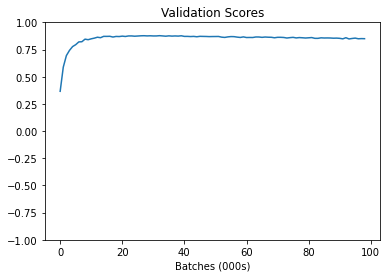

In [184]:
plt.ylim([-1, 1])
plt.plot(list(range(int(num_iter / test_every -1))), val_scores)
plt.xlabel("Batches (000s)")
plt.title("Validation Scores")


In [185]:
preds = predict(X_test, weights)
print("Mean absolute error: ", round(mae(preds, y_test), 4))
print("Root mean squared error:", round(rmse(preds, y_test), 4))


Mean absolute error:  2.4364
Root mean squared error: 3.5196


Learning rate tuning

In [186]:
def r2_score_lr(learning_rate):
    train_info = train(X_train, y_train, X_test, y_test,
                       n_iter=10000,
                       test_every=100,
                       learning_rate=learning_rate,
                       batch_size=13,
                       seed=80718)
    weights = train_info[1]
    preds = predict(X_test, weights)
    return  r2_score(y_test, preds)

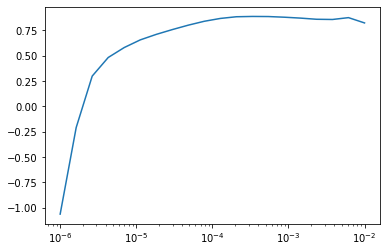

In [187]:
lrs = np.geomspace(1e-2, 1e-6, num=20)
r2s = [r2_score_lr(lr) for lr in lrs]
plt.semilogx(lrs,r2s)

Evaluting best model

In [188]:
train_info = train(X_train, y_train, X_test, y_test,
                   n_iter=10000,
                   learning_rate=0.001,
                   batch_size=23,
                   seed=180807)
losses = train_info[0]
weights = train_info[1]

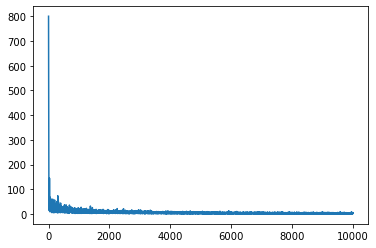

In [189]:
plt.plot(list(range(10000)), losses)

In [190]:
preds = predict(X_test, weights)

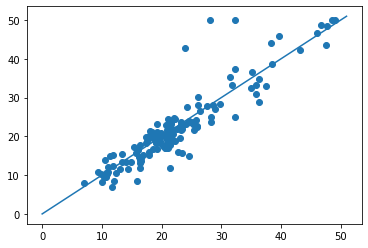

In [191]:
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51])

(6.0, 51.0)

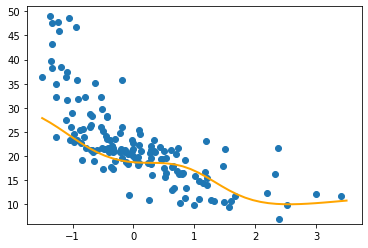

In [192]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)
test_feature = np.concatenate([a, b], axis=1)
preds_test = predict(test_feature, weights)[:, 0]

plt.scatter(X_test[:, 12], preds)
plt.plot(np.array(test_feature[:, -1]), preds_test, linewidth=2, c='orange')
plt.ylim([6, 51])